In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
import os
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from itertools import combinations

In [55]:
df = pd.read_csv('elliptic_txs_features.csv', header=None)
df_edgelist = pd.read_csv('elliptic_txs_edgelist.csv')
df_classes = pd.read_csv('elliptic_txs_classes.csv')
pd.set_option('mode.chained_assignment', None)

## 1. Data cleaning

The script below outlines the steps taken to explore, clean, and prepare the dataset for machine learning applications, focusing on data structure and content adjustments to improve quality and usability:

•	Standardization of Column Names: Column names in the main DataFrame were modified and standardized.

•	Adjustment of Class Labels: The df_classes DataFrame saw its labels updated, with 'unknown' replaced by a numeric value for example.

•	Dataframe Overview: A quick overview of the structure of the three key DataFrames was obtained, providing insight into the data's size and composition.

•	Missing Values Check: A function was implemented to calculate the total and percentage of missing values in each DataFrame. It was found that all three DataFrames contained no missing values.

•	Data Merging: Merging the df DataFrame with df_classes created an integrated dataset ready for further analysis or model training.



In [56]:
# Change column names
colNames1 = {'0': 'txId', 1: "Timestep"}
colNames2 = {str(i+2): "local" + str(i+1) for i in range(93)}
colNames3 = {str(i+95): "aggregated" + str(i+1) for i in range(72)}
colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(j): item_kk for j,item_kk in colNames.items()} 

df = df.rename(columns=colNames)

df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edgelist.shape)
print('Shape of features', df.shape)

# Function to calculate total missing values and percentage
def calculate_missing(df):
    total_missing = df.isna().sum().sum()
    total_cells = df.size
    percentage_missing = (total_missing / total_cells) * 100
    return total_missing, percentage_missing

# Check for missing values in each DataFrame
missing_values_info = []

# For the first DataFrame (df)
missing_values_df, percentage_missing_df = calculate_missing(df)
missing_values_info.append(('df', missing_values_df, f"{percentage_missing_df:.2f}%"))

# For the second DataFrame (df_edgelist)
missing_values_df_edgelist, percentage_missing_df_edgelist = calculate_missing(df_edgelist)
missing_values_info.append(('df_edgelist', missing_values_df_edgelist, f"{percentage_missing_df_edgelist:.2f}%"))

# For the third DataFrame (df_classes)
missing_values_df_classes, percentage_missing_df_classes = calculate_missing(df_classes)
missing_values_info.append(('df_classes', missing_values_df_classes, f"{percentage_missing_df_classes:.2f}%"))

# Create a table using tabulate
print(tabulate(missing_values_info, headers=['DataFrame', 'Total Missing Values', 'Percentage Missing'], tablefmt='fancy_grid'))

df = pd.merge(df, df_classes)
df_complete = df.copy()

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)
╒═════════════╤════════════════════════╤══════════════════════╕
│ DataFrame   │   Total Missing Values │ Percentage Missing   │
╞═════════════╪════════════════════════╪══════════════════════╡
│ df          │                      0 │ 0.00%                │
├─────────────┼────────────────────────┼──────────────────────┤
│ df_edgelist │                      0 │ 0.00%                │
├─────────────┼────────────────────────┼──────────────────────┤
│ df_classes  │                      0 │ 0.00%                │
╘═════════════╧════════════════════════╧══════════════════════╛


## 2. Splitting test data

Following the data preparation phase, the dataset was further refined by splitting it into training and test datasets based on the 'Timestep' feature. This division aimed to examine at which range of timesteps the class distribution within the data becomes most balanced. After analysis, a split approximately adhering to an 80-20 ratio was achieved by selecting timesteps 33 to 42 for the test set, with the remaining data allocated to the training set.

The class distribution within both training and test datasets was calculated to ensure a representative split. The distribution analysis revealed the following:

•	The training data consisted of 77.8% for class 3, 20.0% for class 2, and 2.2% for class 1, indicating a predominant presence of class 3.

•	Similarly, the test data showed a composition of 74.8% for class 3, 22.9% for class 2, and 2.2% for class 1, maintaining a consistent class representation across both datasets.

The proportion of data allocated to the test set was 21.3%, with the remaining 78.7% forming the training set. This distribution strategy ensures both datasets are sufficiently representative of the overall class distribution, facilitating the development of machine learning models that are well-adjusted to the dataset's inherent characteristics.


In [57]:
# Split the data into test and train data 33-42
# Split the data into test and train data 35-43
test_df = df[(df['Timestep'] >= 33) & (df['Timestep'] <= 42)]
train_df = df[(df['Timestep'] > 42) | (df['Timestep'] < 33)]

# Calculate class distribution in training and testing DataFrames
train_counts = train_df['class'].value_counts().reset_index()
train_counts.columns = ['Class', 'Count']
train_percentage = (train_counts['Count'] / len(train_df)) * 100
train_counts['Percentage'] = train_percentage.apply(lambda x: f"{x:.1f}%")

test_counts = test_df['class'].value_counts().reset_index()
test_counts.columns = ['Class', 'Count']
test_percentage = (test_counts['Count'] / len(test_df)) * 100
test_counts['Percentage'] = test_percentage.apply(lambda x: f"{x:.1f}%")

# Print tabulate table
print("Training Data Class Distribution:")
print(tabulate(train_counts, headers='keys', tablefmt='fancy_grid'))
print("\nTesting Data Class Distribution:")
print(tabulate(test_counts, headers='keys', tablefmt='fancy_grid'))

# Calculating the percentage of data in test and train sets
total_length = len(df)
test_percent = f"{len(test_df) / total_length * 100:.1f}%"
train_percent = f"{len(train_df) / total_length * 100:.1f}%"

print("\nPercentage of data in the test set:", test_percent)
print("Percentage of data in the train set:", train_percent)

Training Data Class Distribution:
╒════╤═════════╤═════════╤══════════════╕
│    │   Class │   Count │ Percentage   │
╞════╪═════════╪═════════╪══════════════╡
│  0 │       3 │  124687 │ 77.8%        │
├────┼─────────┼─────────┼──────────────┤
│  1 │       2 │   32054 │ 20.0%        │
├────┼─────────┼─────────┼──────────────┤
│  2 │       1 │    3571 │ 2.2%         │
╘════╧═════════╧═════════╧══════════════╛

Testing Data Class Distribution:
╒════╤═════════╤═════════╤══════════════╕
│    │   Class │   Count │ Percentage   │
╞════╪═════════╪═════════╪══════════════╡
│  0 │       3 │   32518 │ 74.8%        │
├────┼─────────┼─────────┼──────────────┤
│  1 │       2 │    9965 │ 22.9%        │
├────┼─────────┼─────────┼──────────────┤
│  2 │       1 │     974 │ 2.2%         │
╘════╧═════════╧═════════╧══════════════╛

Percentage of data in the test set: 21.3%
Percentage of data in the train set: 78.7%


## 3. EDA

The EDA provides an in-depth look at the distribution and characteristics of transactions within the dataset, which is vital for uncovering patterns and potential anomalies. The EDA has yielded several key findings:

•	Transaction Class Distribution: The bar chart illustrates the skewed distribution of transactions, dominated by 'Unknown' classes. With such a substantial imbalance where 'Illicit' transactions form a minor percentage, machine learning models might struggle to detect the underrepresented class without intervention. Addressing this imbalance through sampling techniques or specialized algorithms will be important to enhance model performance.

•	Transactions Over Time: The time step plot shows fluctuations in the number of transactions over time, which are crucial for understanding temporal patterns. These patterns may influence how a predictive model interprets transaction volumes and their relation to potentially illicit activities.

•	Class-wise Transaction Trends: The analysis indicates fluctuations in the volume of transactions for each class over time, with the line plot and stacked bar chart detailing these variations. Although the 'Unknown' category consistently shows the highest volume, the 'Illicit' transactions also exhibit considerable fluctuation. This variability suggests that the frequency of illicit activities is not constant over time, which could have implications for temporal pattern recognition and anomaly detection in predictive modeling.

•	Focus on Illicit Transactions: Highlighting the time steps with the highest and lowest counts of illicit transactions helps pinpoint critical periods for further investigation. This targeted approach is essential for developing models that can effectively identify and predict illicit transactions.


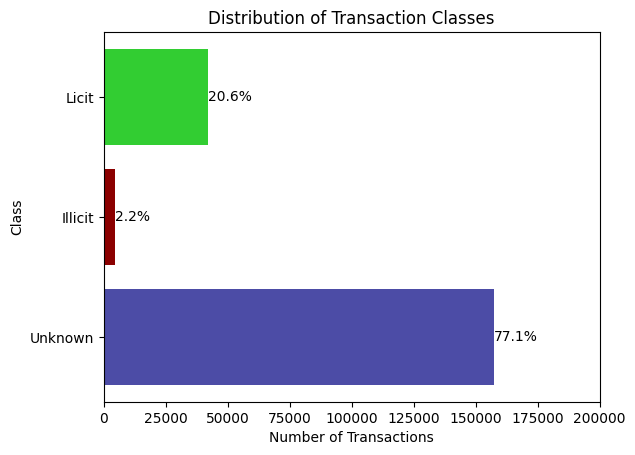

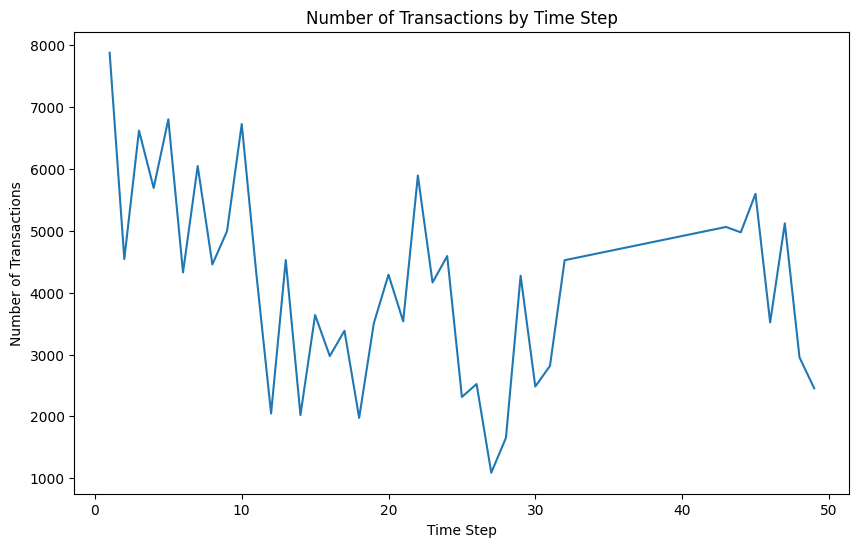

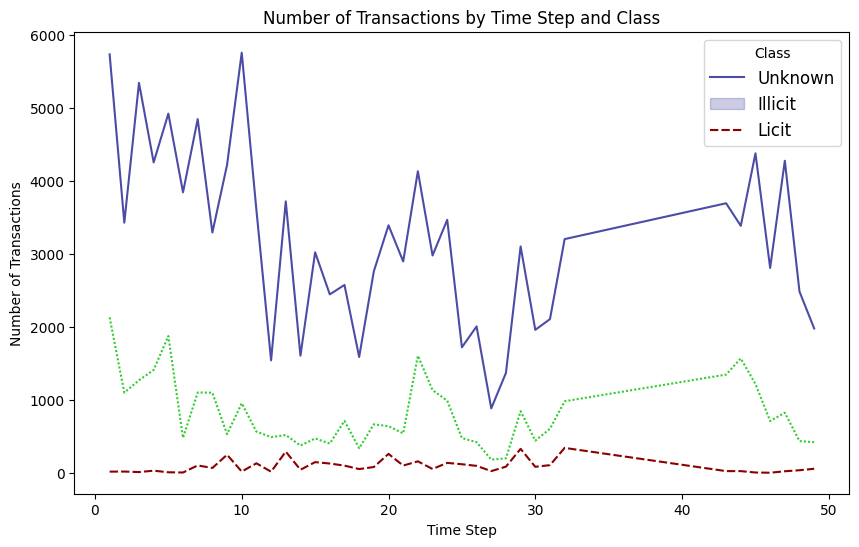

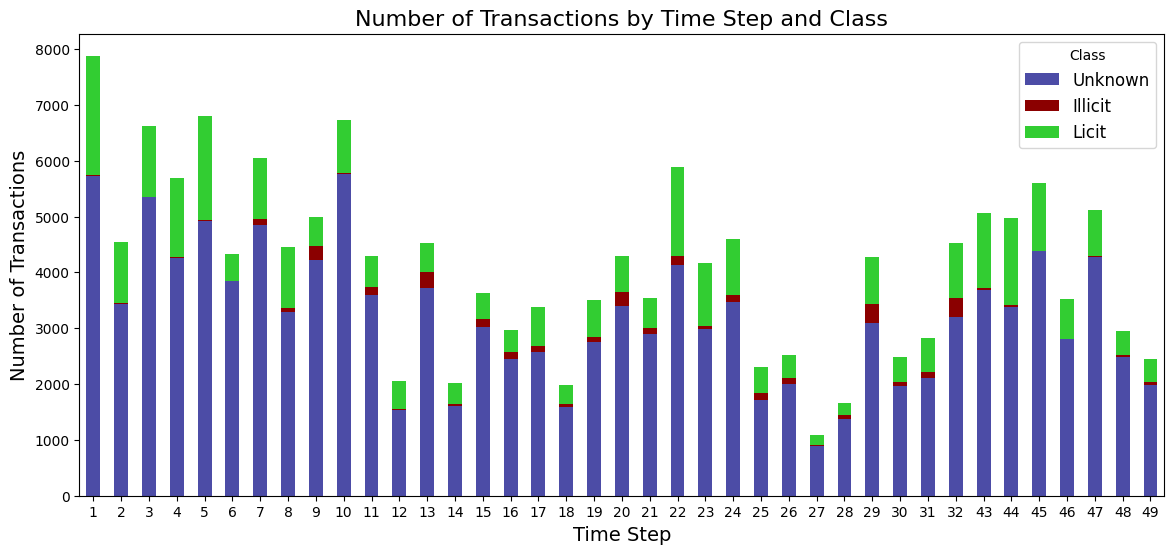

Three time steps with the highest illicit transaction count:
╒═════════════╤═══════════════════════════════════════╕
│   Time Step │   Illicit Transaction Count (Highest) │
╞═════════════╪═══════════════════════════════════════╡
│          32 │                                   342 │
├─────────────┼───────────────────────────────────────┤
│          29 │                                   329 │
├─────────────┼───────────────────────────────────────┤
│          13 │                                   291 │
╘═════════════╧═══════════════════════════════════════╛

Three time steps with the lowest illicit transaction count:
╒═════════════╤══════════════════════════════════════╕
│   Time Step │   Illicit Transaction Count (Lowest) │
╞═════════════╪══════════════════════════════════════╡
│          46 │                                    2 │
├─────────────┼──────────────────────────────────────┤
│           6 │                                    5 │
├─────────────┼─────────────────────────────

In [58]:
# Custom color palette
colors = [(0, 0, 0.5, 0.7), 'darkred', 'limegreen']

# Grouping by class and counting occurrences
group_class = df_classes.groupby('class').count()

# Calculate total transactions
total_transactions = group_class['txId'].sum()

# Calculate percentages
percentages = (group_class['txId'] / total_transactions) * 100

# Plotting
bars = plt.barh(['Unknown', 'Illicit', 'Licit'], group_class['txId'].values, color=colors)

# Annotate percentages on bars
for bar, p, prc in zip(bars, group_class['txId'].values, percentages):
    plt.text(p, bar.get_y() + bar.get_height()/2, f'{prc:.1f}%', ha='left', va='center', fontsize=10)

# Adding labels and title
plt.xlabel('Number of Transactions')
plt.ylabel('Class')
plt.title('Distribution of Transaction Classes')

# Show plot
plt.xlim(0, 200000)
plt.show()

# Grouping by time step and counting occurrences
group_feature = train_df.groupby(train_df['Timestep']).count()

# Plotting
group_feature['txId'].plot(figsize=(10, 6))

# Adding labels and title
plt.title('Number of Transactions by Time Step')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')

# Show plot
plt.show()

# Grouping by time step and counting occurrences for each class
grouped_df = train_df.groupby(['Timestep', 'class']).size().unstack(fill_value=0)

# Create figure and axes for line plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting line plot
sns.lineplot(data=grouped_df, palette=colors, ax=ax)

# Adding labels and title
plt.title('Number of Transactions by Time Step and Class')
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')

# Customize legend
plt.legend(['Unknown', 'Illicit', 'Licit'], title='Class', fontsize=12)

# Show plot
plt.show()

# Create figure and axes for bar plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plotting bar plot
grouped_df.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding labels and title
plt.title('Number of Transactions by Time Step and Class', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=0) 

# Customize legend
plt.legend(['Unknown', 'Illicit', 'Licit'], title='Class', fontsize=12)

# Show plot
plt.show()

# Filter DataFrame for illicit transactions
illicit_df = train_df[train_df['class'] == '1']

# Group by time step and count occurrences
illicit_count = illicit_df.groupby('Timestep').size()

# Find the three time steps with the highest illicit transaction count
highest_counts = illicit_count.nlargest(3)

# Find the three time steps with the lowest illicit transaction count
lowest_counts = illicit_count.nsmallest(3)

# Convert the series to a DataFrame for tabulation
table_highest = highest_counts.reset_index()
table_highest.columns = ['Time Step', 'Illicit Transaction Count (Highest)']

table_lowest = lowest_counts.reset_index()
table_lowest.columns = ['Time Step', 'Illicit Transaction Count (Lowest)']

# Print tables using tabulate
print("Three time steps with the highest illicit transaction count:")
print(tabulate(table_highest, headers='keys', tablefmt='fancy_grid', showindex=False))
print("\nThree time steps with the lowest illicit transaction count:")
print(tabulate(table_lowest, headers='keys', tablefmt='fancy_grid', showindex=False))

## 4. Feature Engineering

In the process of refining the data for predictive modeling, an elaborate feature engineering approach was undertaken to distill the essential information within the dataset.

Initially, a correlation analysis was executed to determine which features showed the most significant relationship with the 'class' variable, indicating potential predictive power. This examination resulted in a distilled list of the top 10 features based on their correlation strengths. While such an approach directly considers linear associations, it is a preliminary step that highlights which features could warrant further scrutiny.

To address multicollinearity and reduce the dimensionality of the dataset, Principal Component Analysis was employed. PCA transforms the data into a set of orthogonal components that explain a cumulative percentage of the variance. The PCA curve's 'elbow,' where the rate of increase in explained variance by additional components diminishes, was identified quite late. This suggested that a substantial number of components still contributed meaningful information. As a result, 62 components were selected to account for 98% of the variance. The choice was driven by the desire to retain as much information as possible, as the components continued to add value up to that point.

The Variance Inflation Factor (VIF) was also considered, which is a measure of how much a particular variable is contributing to the standard error in the model due to high multicollinearity. After applying VIF, only five features remained. However, such a drastic reduction in features led to a significant decrease in model performance. 

After considering both PCA and VIF for feature selection, it became clear that using only the five features determined by VIF led to a decrease in the model's performance. Since the PCA approach with 62 components retained a substantial amount of variance and essential information, it was chosen as the preferable method. This decision was based on maintaining a balance between a comprehensive representation of the dataset and the model's ability to perform well.


Top 10 Features based on Correlation with the 'class' column:
╒════════╤═══════════╤═══════════════╕
│   Rank │ Feature   │   Correlation │
╞════════╪═══════════╪═══════════════╡
│      1 │ local53   │      0.411221 │
├────────┼───────────┼───────────────┤
│      2 │ local55   │      0.338676 │
├────────┼───────────┼───────────────┤
│      3 │ local54   │      0.334673 │
├────────┼───────────┼───────────────┤
│      4 │ local59   │      0.250415 │
├────────┼───────────┼───────────────┤
│      5 │ local65   │      0.250401 │
├────────┼───────────┼───────────────┤
│      6 │ local52   │      0.245856 │
├────────┼───────────┼───────────────┤
│      7 │ local60   │      0.239218 │
├────────┼───────────┼───────────────┤
│      8 │ local66   │      0.239206 │
├────────┼───────────┼───────────────┤
│      9 │ local61   │      0.235003 │
├────────┼───────────┼───────────────┤
│     10 │ local67   │      0.234993 │
╘════════╧═══════════╧═══════════════╛


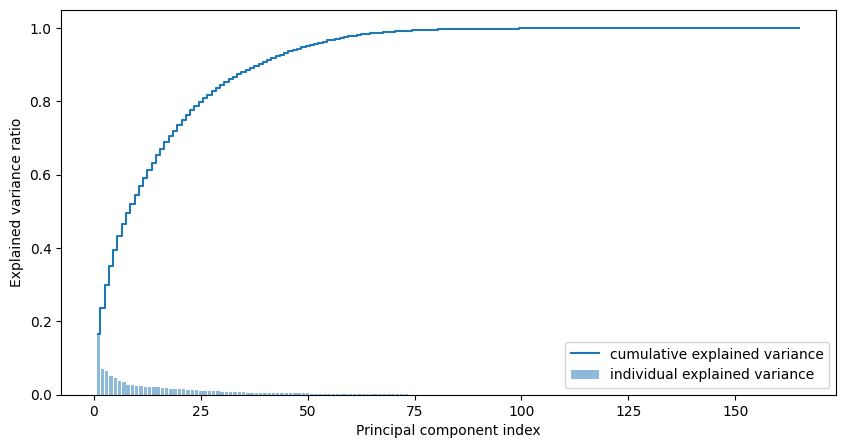

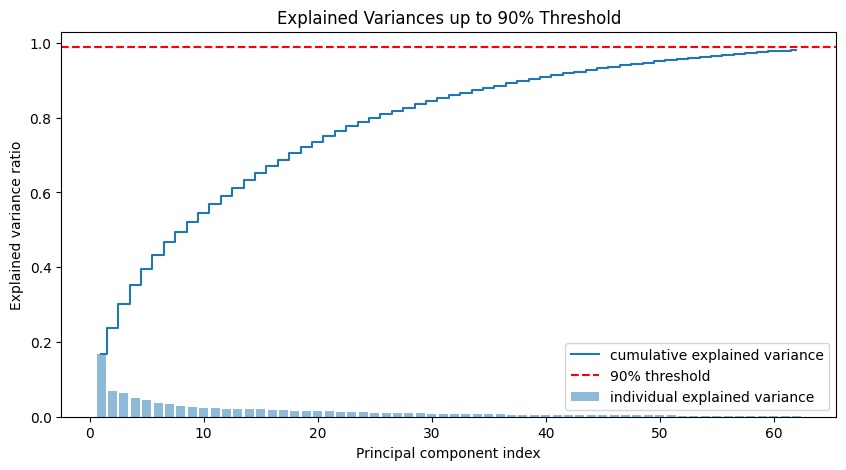

╒═══════════╤════════════════════════════╕
│ Feature   │   Explained Variance Ratio │
╞═══════════╪════════════════════════════╡
│ local1    │                 0.166499   │
├───────────┼────────────────────────────┤
│ local2    │                 0.0697471  │
├───────────┼────────────────────────────┤
│ local3    │                 0.0642267  │
├───────────┼────────────────────────────┤
│ local4    │                 0.0509475  │
├───────────┼────────────────────────────┤
│ local5    │                 0.0444472  │
├───────────┼────────────────────────────┤
│ local6    │                 0.0371225  │
├───────────┼────────────────────────────┤
│ local7    │                 0.0337113  │
├───────────┼────────────────────────────┤
│ local8    │                 0.0276162  │
├───────────┼────────────────────────────┤
│ local9    │                 0.0271709  │
├───────────┼────────────────────────────┤
│ local10   │                 0.0243472  │
├───────────┼────────────────────────────┤
│ local11  

In [59]:
# Make a copy of the DataFrame
df_copy = train_df.copy()

# Convert 'class' column to integer type in the copy
df_copy['class'] = df_copy['class'].astype(int)

# Calculate the correlation matrix for the copy
correlation_matrix = df_copy.corr()

# Exclude 'txId' and 'Timestep' columns from the correlation matrix
correlation_to_class = correlation_matrix['class'].drop(['txId', 'Timestep', 'class'])

# Sort correlation values in descending order
ranked_features = correlation_to_class.abs().sort_values(ascending=False)

# Extract the top 10 ranked features
top_10_ranked_features = ranked_features.head(10)

# Create a DataFrame with top 10 ranked features
top_10_ranked_features_df = pd.DataFrame({'Rank': range(1, 11), 'Feature': top_10_ranked_features.index, 'Correlation': top_10_ranked_features.values})

# Print the top 10 ranked features using tabulate, ensuring 'Rank' is the first column
print("Top 10 Features based on Correlation with the 'class' column:")
print(tabulate(top_10_ranked_features_df[['Rank', 'Feature', 'Correlation']], headers='keys', tablefmt='fancy_grid', showindex=False))

# # Make a copy of the original DataFrame
df_copy = train_df.copy()

# Drop rows with 'class' column value equal to 3
df_copy = df_copy[df_copy['class'] != 3]

columns_to_drop = ['txId', 'Timestep', 'class']

df_copy.drop(columns_to_drop, axis=1, inplace=True)# Perform PCA on the modified DataFrame
pca = PCA()
pca_comps = pca.fit_transform(df_copy) # pca components
var_exp = pca.explained_variance_ratio_ # variance explained ratio 
cum_var_exp = np.cumsum(var_exp) # cumulative variance

# Plot explained variances
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(var_exp) + 1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

# Set column names as x-axis tick labels


plt.legend(loc='best')
plt.show()

# Calculate the number of components required to explain 90% of variance
n_components_99 = np.argmax(cum_var_exp >= 0.98) + 1

# Plot explained variances up to 80% threshold
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(1, n_components_99 + 1), var_exp[:n_components_99], alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, n_components_99 + 1), cum_var_exp[:n_components_99], where='mid', label='cumulative explained variance')
plt.axhline(y=0.99, color='r', linestyle='--', label='90% threshold')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variances up to 90% Threshold')
plt.legend(loc='best')
# Set column names as x-axis tick labels

plt.show()

# Features to keep based on 90% threshold
most_important_features = df_copy.columns[:n_components_99]

# Create a fancy grid table
table = [["Feature", "Explained Variance Ratio"],
         *zip(most_important_features, var_exp[:n_components_99])]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Save the most important features to a list
most_important_features = list(most_important_features)

# List of columns to keep in addition to ['txId', 'Timestep', 'class']
columns_to_keep = ['txId', 'Timestep', 'class'] + most_important_features
columns_to_keep_2 = ['class'] + most_important_features

# Drop rows with 'class' column value equal to 3
df_new = train_df[train_df['class'] != 3]

# Drop columns not in the list of most important features
df_new = df_new[columns_to_keep]

# Print the lenght of PCA features
print("Amount of features kept:", len(most_important_features))


## 5. Dataset generation

In the dataset generation phase, the groundwork was laid out with a systematic approach to configure the data for subsequent modelling. A copy of the new Data Frame was created with a slight modification to the 'class' column label, renaming it to 'class_' to prevent any potential issues with reserved keywords in the modelling process.

A custom class, TrainTestSplitter, was devised to orchestrate the splitting of data into distinct training, validation, and test segments. Care was taken to exclude data points labeled with 'class_' equal to 3, as they may not align with the model's predictive goals. Upon executing the split, the data was apportioned, dedicating 80% to training purposes and setting aside 20% for validation. The split was conducted using a fixed random seed to ensure reproducibility, a key aspect for maintaining experimental integrity.

The actual separation of features and labels was carried out with precision, removing identifiers and timestamps from the feature set, WHY?. Labels were filtered to focus on 'Illicit' and 'Licit' transactions, corresponding to classes 1 and 2. For model tuning and validation, the training and validation datasets were merged, providing a comprehensive pool of data for cross-validation procedures.

Finally, an evaluation of the class distribution across the datasets affirmed a consistent 90/10 ratio of 'Licit' to 'Illicit' transactions. This uniformity is vital to prevent any model bias towards the more prevalent class and ensures that the resulting model can identify patterns pertaining to both classes effectively.

With a clear structure and balanced distribution, the dataset is now primed for the modeling stage, aiming to yield a model that can generalize robustly to new data while discriminating accurately between the different transaction types.


In [60]:
df_set = df_new.copy()
# Rename the 'class' column to 'class_'
df_set.rename(columns={'class': 'class_'}, inplace=True)

class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        # Drop rows with class_ equal to 3
        df2 = df[df['class_'] != 3]
        self.total_n_illicit = df2.loc[df2['class_'] == 1].shape[0]
        self.total_n_licit = df2.loc[df2['class_'] == 2].shape[0]
        self.train_set = df2.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df2.loc[~df2['txId'].isin(self.train_set['txId'])].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[~self.train_set['txId'].isin(self.validation_set['txId'])].reset_index(drop=True)
        print("Split completed")

# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()
fitting_splits.split_train_test(df_set)

# Prepare all the data for subsequent use
# Training Set
X_train = fitting_splits.train_set[fitting_splits.train_set['class_'].isin(['1', '2'])]

# Drop unnecessary columns from the training set
X_train = X_train.drop(['txId', 'class_', 'Timestep'], axis=1)

# Extract the target variable for the training set (square root of selling price)
y_train = fitting_splits.train_set.loc[fitting_splits.train_set['class_'].isin(['1', '2']), 'class_']

# Validation Set
X_validation = fitting_splits.validation_set[fitting_splits.validation_set['class_'].isin(['1', '2'])]

# Drop unnecessary columns from the validation set
X_validation = X_validation.drop(['txId', 'class_', 'Timestep'], axis=1)

# Extract the target variable for the validation set (square root of selling price)
y_validation = fitting_splits.validation_set.loc[fitting_splits.validation_set['class_'].isin(['1', '2']), 'class_']

# Test Set
X_test = fitting_splits.test_set[fitting_splits.test_set['class_'].isin(['1', '2'])]

# Drop unnecessary columns from the test set
X_test = X_test.drop(['txId', 'class_', 'Timestep'], axis=1)

# Extract the target variable for the test set (square root of selling price)
y_test = fitting_splits.test_set.loc[fitting_splits.test_set['class_'].isin(['1', '2']), 'class_']

# Combine Training and Validation Sets for Cross-Validation
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, y_validation])

# Convert the data type of the labels from object to integer
y_train_validation = y_train_validation.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Function to format percentages
def format_percent(percent):
    return "{:.2f} %".format(percent)

count_train = y_train.value_counts()
percent_train = count_train / len(y_train) * 100
table_train = pd.DataFrame({'Count': count_train, 'Percentage': percent_train.map(format_percent)})

count_val = y_validation.value_counts()
percent_val = count_val / len(y_validation) * 100
table_val = pd.DataFrame({'Count': count_val, 'Percentage': percent_val.map(format_percent)})

count_test = y_test.value_counts()
percent_test = count_test / len(y_test) * 100
table_test = pd.DataFrame({'Count': count_test, 'Percentage': percent_test.map(format_percent)})

# Print the tables
print("Training Data:")
print(tabulate(table_train, headers='keys', tablefmt='fancy_grid'))
print("\nValidation Data:")
print(tabulate(table_val, headers='keys', tablefmt='fancy_grid'))
print("\nTest Data:")
print(tabulate(table_test, headers='keys', tablefmt='fancy_grid'))

Generating the train/validation/test splits...
Split completed
Training Data:
╒════╤═════════╤══════════════╕
│    │   Count │ Percentage   │
╞════╪═════════╪══════════════╡
│  2 │   20521 │ 90.00 %      │
├────┼─────────┼──────────────┤
│  1 │    2279 │ 10.00 %      │
╘════╧═════════╧══════════════╛

Validation Data:
╒════╤═════════╤══════════════╕
│    │   Count │ Percentage   │
╞════╪═════════╪══════════════╡
│  2 │    5101 │ 89.49 %      │
├────┼─────────┼──────────────┤
│  1 │     599 │ 10.51 %      │
╘════╧═════════╧══════════════╛

Test Data:
╒════╤═════════╤══════════════╕
│    │   Count │ Percentage   │
╞════╪═════════╪══════════════╡
│  2 │    6432 │ 90.27 %      │
├────┼─────────┼──────────────┤
│  1 │     693 │ 9.73 %       │
╘════╧═════════╧══════════════╛


## 6. Predicting unknowns using Random Forest

In this analysis, a Random Forest classifier is utilized to predict unknown transaction classes, aiming to categorize them into 'Licit' and 'Illicit', thus employing a semi-supervised learning approach. By treating initially unidentified transactions as new data points for prediction, the model effectively leverages the labeled data to infer the classifications of the unlabeled ones.

Hyperparameter tuning plays a critical role in optimizing the Random Forest model, ensuring that the best possible parameters are selected to maximize its predictive performance. The process involves adjusting several key parameters, such as the number of trees, maximum depth, minimum samples per leaf, and whether to bootstrap samples, to find the optimal configuration for the model.

The outcomes of the hyperparameter tuning reveal a model configured with a specific set of parameters that deliver promising results. The performance metrics of the model, including an accuracy of 98.46%, an F1 score of 91.54%, a precision of 98.02%, and a recall of 85.86%, highlight its effectiveness. These results are particularly noteworthy, considering the model's ability to minimize false positives and false negatives, with counts of 98 and 12, respectively.

Following the model's application to predict the classes of previously unknown transactions, a significant reclassification was achieved. The model predicted a substantial number of transactions as 'Licit' (72.28%) and a smaller fraction as 'Illicit' (5.50%), reflecting a nuanced understanding of the transaction characteristics that differentiate between these classes. This reclassification effort not only enriches the dataset with new insights but also demonstrates the model's capacity to discern complex patterns within the data.

Using a Random Forest classifier and careful hyperparameter tuning, the project tackled classifying unknown transactions well. This method proved the model's effectiveness in accurately identifying transaction categories and allowed us to keep and use a large part of the dataset instead of removing the unknown transactions, a common issue with unlabelled data. This approach shows how semi-supervised learning can make the most of the data at hand, capturing important insights from all available information.


╒═══════════════════════╤═════════╕
│ Hyperparameter        │ Value   │
╞═══════════════════════╪═════════╡
│ Number of Trees       │ 190     │
├───────────────────────┼─────────┤
│ Maximum Depth         │ 20      │
├───────────────────────┼─────────┤
│ Minimum Samples Split │ 2       │
├───────────────────────┼─────────┤
│ Minimum Samples Leaf  │ 1       │
├───────────────────────┼─────────┤
│ Maximum Features      │ sqrt    │
╘═══════════════════════╧═════════╛
╒════════════╤══════════╕
│ Metric     │       F1 │
╞════════════╪══════════╡
│ Best Score │ 0.917768 │
╘════════════╧══════════╛
╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 98.46%  │
├─────────────────┼─────────┤
│ F1 Score        │ 91.54%  │
├─────────────────┼─────────┤
│ Precision       │ 98.02%  │
├─────────────────┼─────────┤
│ Recall          │ 85.86%  │
├─────────────────┼─────────┤
│ False Positives │ 98      │
├─────────────────┼─────────┤
│ False Nega

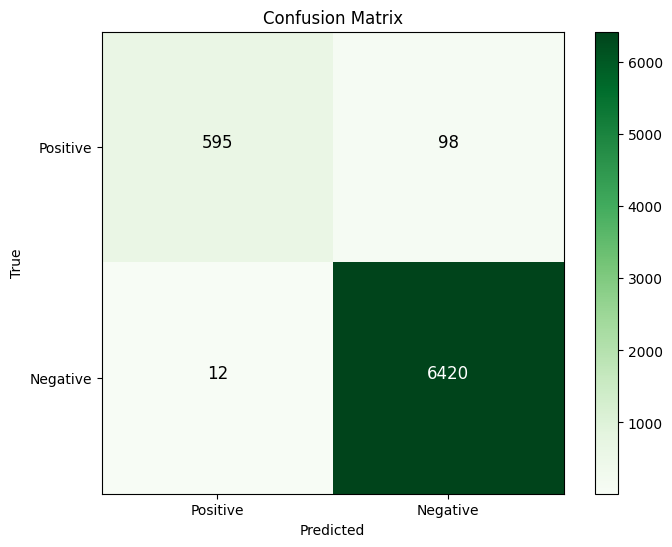

╒═════════════════════════╤═══════════════════╤═════════╤══════════════╕
│                         │   Predicted Class │ Count   │   Percentage │
╞═════════════════════════╪═══════════════════╪═════════╪══════════════╡
│ Predicted Class 1 Count │              8820 │ 5.50%   │            0 │
├─────────────────────────┼───────────────────┼─────────┼──────────────┤
│ Predicted Class 2 Count │            115867 │ 72.28%  │            0 │
╘═════════════════════════╧═══════════════════╧═════════╧══════════════╛
╒════╤═════════╤═════════╤══════════════╕
│    │   Class │   Count │   Percentage │
╞════╪═════════╪═════════╪══════════════╡
│  0 │       2 │  147921 │      92.2707 │
├────┼─────────┼─────────┼──────────────┤
│  1 │       1 │   12391 │       7.7293 │
╘════╧═════════╧═════════╧══════════════╛


In [61]:
# Check if the pickle file exists
pickle_file = "rf_grid_search_results.pkl"
if os.path.exists(pickle_file):
    
    # Load the results from the pickle file
    with open(pickle_file, 'rb') as f:
        grid_search_results = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid = {
        "n_estimators": [x for x in range(10, 200, 10)],
        "max_depth": [x for x in range(5, 21, 5)],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    }
    sklearn_grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1, scoring='f1')
    sklearn_grid_search_rf.fit(X_train_validation, y_train_validation)
    
    # Save the results to a pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(sklearn_grid_search_rf, f)
    
    grid_search_results = sklearn_grid_search_rf

best_random_forest = grid_search_results.best_estimator_

# Prepare data as a list of lists
data = [
    ["Number of Trees", best_random_forest.n_estimators],
    ["Maximum Depth", best_random_forest.max_depth],
    ["Minimum Samples Split", best_random_forest.min_samples_split],
    ["Minimum Samples Leaf", best_random_forest.min_samples_leaf],
    ["Maximum Features", best_random_forest.max_features]
]

# Print table
print(tabulate(data, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))

best_score = grid_search_results.best_score_

# Prepare data as a list of lists
data = [
    ["Best Score", best_score]
]

# Print table
print(tabulate(data, headers=["Metric", "F1"], tablefmt="fancy_grid"))

# Predict using the trained model
y_hat_test = grid_search_results.predict(X_test)

# Calculate the accuracy, F1 score, precision, and recall
accuracy = accuracy_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)

# Convert scores to percentages
accuracy_percent = accuracy * 100
f1_percent = f1 * 100
precision_percent = precision * 100
recall_percent = recall * 100

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate false positives and false negatives
false_positives = fp
false_negatives = fn

# Prepare data as a list of lists
data = [
    ["Accuracy", f"{accuracy_percent:.2f}%"],
    ["F1 Score", f"{f1_percent:.2f}%"],
    ["Precision", f"{precision_percent:.2f}%"],
    ["Recall", f"{recall_percent:.2f}%"],
    ["False Positives", false_positives],
    ["False Negatives", false_negatives]
]

# Print table
print(tabulate(data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Get the predicted classes
y_pred = grid_search_results.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define display labels
display_labels = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Greens')

# Add annotations with custom colors
for i in range(len(display_labels)):
    for j in range(len(display_labels)):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        plt.text(j, i, format(cm[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=display_labels)
plt.yticks(ticks=[0, 1], labels=display_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

df_original = train_df.copy()
df_original = train_df[columns_to_keep]

# Drop columns 'txID' and 'Timestep'
df_original.drop(['txId', 'Timestep'], axis=1, inplace=True)

# Filter rows with class column value 3
rows_with_3 = df_original[df_original['class'] == 3]

# Extract features for prediction (assuming X contains features used for training)
X_to_predict = rows_with_3.drop(columns=['class'])

# Predict class labels for the rows where the class column has the value 3
predicted_classes = grid_search_results.predict(X_to_predict)

# Create a new column in the DataFrame for predicted classes
df_original['predicted_classes'] = df_original['class']  # Initialize with original class values
df_original.loc[train_df['class'] == 3, 'predicted_classes'] = predicted_classes  # Update with predicted values for class 3 rows

# Calculate the total number of predictions
total_predictions = len(df_original)

# Calculate the number of predicted classes 1 and 2
predicted_class_counts = df_original['predicted_classes'].value_counts()

# Calculate the percentage of each predicted class
total_class_1 = df_original[df_original['class'] == 1].shape[0]
total_class_2 = df_original[df_original['class'] == 2].shape[0]
percentage_class_1 = (predicted_class_counts.get(1, 0) / total_predictions) * 100
percentage_class_2 = (predicted_class_counts.get(2, 0) / total_predictions) * 100

# Calculate the number of predictions that were originally class 1 or 2
class_1_as_1_count = ((df_original['class'] == 1) & (df_original['predicted_classes'] == 1)).sum()
class_2_as_2_count = ((df_original['class'] == 2) & (df_original['predicted_classes'] == 2)).sum()

# Create a table with the statistics
table = [
    ["Predicted Class 1 Count", predicted_class_counts.get(1, 0), f"{percentage_class_1:.2f}%", class_1_as_1_count],
    ["Predicted Class 2 Count", predicted_class_counts.get(2, 0), f"{percentage_class_2:.2f}%", class_2_as_2_count]
]

# Display the table using tabulate
print(tabulate(table, headers=["Predicted Class", "Count", "Percentage"], tablefmt="fancy_grid"))

df_original['predicted_classes'] = df_original['predicted_classes'].astype(int)

# Calculate value counts and percentages
predicted_classes_counts = df_original['predicted_classes'].value_counts()
total_samples = len(df_original)
percentage = (predicted_classes_counts / total_samples) * 100

# Create DataFrame to hold value counts and percentages
statistics_df = pd.DataFrame({'Class': predicted_classes_counts.index, 'Count': predicted_classes_counts.values, 'Percentage': percentage.values})

# Print tabulate table
print(tabulate(statistics_df, headers='keys', tablefmt='fancy_grid'))

## 7. Machine learning techniques paper: Random forest

Following the approach outlined in a key paper, this project employs the same models, particularly focusing on Random Forest, known for its effectiveness in handling complex datasets and providing high accuracy and interpretability. The model is adept at classification tasks, making it ideal for distinguishing between 'Licit' and 'Illicit' transactions.

Hyperparameter Tuning:

•	A systematic grid search was conducted to fine-tune the Random Forest model, exploring a range of values for parameters such as the number of trees, maximum depth, minimum samples per leaf, and bootstrap options.
•	The process utilized cross-validation to ensure the model's robustness and generalizability, with the best parameters saved in a pickle file for efficiency.

Model Performance:

•	The best configuration identified includes 30 trees, a maximum depth of 20, and a minimum of one sample per leaf, using the square root of the number of features.
•	The model achieved a high F1 score of 0.889928, indicating a strong balance between precision and recall.

Results:

•	Accuracy reached 97.69%, showcasing the model's overall effectiveness.
•	Precision was exceptionally high at 99.86%, though recall was lower at 74.13%, suggesting the model was more conservative in predicting 'Illicit' transactions.
•	The confusion matrix and calculated metrics like false positives (252) and false negatives (1) provide deeper insights into the model's predictive capabilities and areas for improvement.


In [62]:
# Extract features and target variable for training/validation
X_train_validation = df_original.drop(columns=['class', 'predicted_classes'])
y_train_validation = df_original['predicted_classes']

# Extract features and target variable for testing
X_test = test_df[test_df['class'] != 3][X_train_validation.columns]
# Convert 'class' column values to integers
test_df['class'] = test_df['class'].astype(int)

# Filter 'class' column where values are not equal to 3
y_test = test_df[test_df['class'] != 3]['class']

╒═══════════════════════╤═════════╕
│ Hyperparameter        │ Value   │
╞═══════════════════════╪═════════╡
│ Number of Trees       │ 30      │
├───────────────────────┼─────────┤
│ Maximum Depth         │ 20      │
├───────────────────────┼─────────┤
│ Minimum Samples Split │ 2       │
├───────────────────────┼─────────┤
│ Minimum Samples Leaf  │ 1       │
├───────────────────────┼─────────┤
│ Maximum Features      │ sqrt    │
╘═══════════════════════╧═════════╛
╒════════════╤══════════╕
│ Metric     │       F1 │
╞════════════╪══════════╡
│ Best Score │ 0.889928 │
╘════════════╧══════════╛
╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 97.69%  │
├─────────────────┼─────────┤
│ F1 Score        │ 85.09%  │
├─────────────────┼─────────┤
│ Precision       │ 99.86%  │
├─────────────────┼─────────┤
│ Recall          │ 74.13%  │
├─────────────────┼─────────┤
│ False Positives │ 252     │
├─────────────────┼─────────┤
│ False Nega

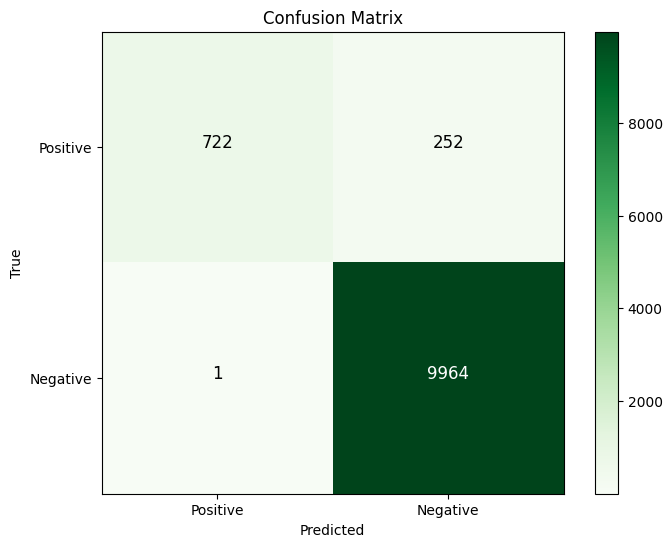

In [63]:
# Check if the pickle file exists
pickle_file_rf = "rf_grid_search_results2.pkl"
if os.path.exists(pickle_file_rf):
    
    # Load the results from the pickle file
    with open(pickle_file_rf, 'rb') as f:
        grid_search_results_rf = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid_rf = {
        "n_estimators": [x for x in range(10, 200, 10)],
        "max_depth": [x for x in range(5, 21, 5)],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    }
    sklearn_grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1, scoring='f1')
    sklearn_grid_search_rf.fit(X_train_validation, y_train_validation)
    
    # Save the results to a pickle file
    with open(pickle_file_rf, 'wb') as f:
        pickle.dump(sklearn_grid_search_rf, f)
    
    grid_search_results_rf = sklearn_grid_search_rf

best_random_forest_rf = grid_search_results_rf.best_estimator_

# Prepare data as a list of lists
data_rf = [
    ["Number of Trees", best_random_forest_rf.n_estimators],
    ["Maximum Depth", best_random_forest_rf.max_depth],
    ["Minimum Samples Split", best_random_forest_rf.min_samples_split],
    ["Minimum Samples Leaf", best_random_forest_rf.min_samples_leaf],
    ["Maximum Features", best_random_forest_rf.max_features]
]

# Print table
print(tabulate(data_rf, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))

best_score_rf = grid_search_results_rf.best_score_

# Prepare data as a list of lists
data_rf = [
    ["Best Score", best_score_rf]
]

# Print table
print(tabulate(data_rf, headers=["Metric", "F1"], tablefmt="fancy_grid"))

# Predict using the trained model
y_hat_test_rf = grid_search_results_rf.predict(X_test)

# Calculate the accuracy, F1 score, precision, and recall
accuracy_rf = accuracy_score(y_test, y_hat_test_rf)
f1_rf = f1_score(y_test, y_hat_test_rf)
precision_rf = precision_score(y_test, y_hat_test_rf)
recall_rf = recall_score(y_test, y_hat_test_rf)

# Convert scores to percentages
accuracy_percent_rf = accuracy_rf * 100
f1_percent_rf = f1_rf * 100
precision_percent_rf = precision_rf * 100
recall_percent_rf = recall_rf * 100

# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_hat_test_rf)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()

# Calculate false positives and false negatives
false_positives_rf = fp_rf
false_negatives_rf = fn_rf

# Prepare data as a list of lists
data_rf = [
    ["Accuracy", f"{accuracy_percent_rf:.2f}%"],
    ["F1 Score", f"{f1_percent_rf:.2f}%"],
    ["Precision", f"{precision_percent_rf:.2f}%"],
    ["Recall", f"{recall_percent_rf:.2f}%"],
    ["False Positives", false_positives_rf],
    ["False Negatives", false_negatives_rf]
]

# Print table
print(tabulate(data_rf, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Get the predicted classes
y_pred_rf = grid_search_results_rf.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Define display labels
display_labels_rf = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(cm_rf, cmap='Greens')

# Add annotations with custom colors
for i in range(len(display_labels_rf)):
    for j in range(len(display_labels_rf)):
        color = 'white' if cm_rf[i, j] > cm_rf.max() / 2 else 'black'
        plt.text(j, i, format(cm_rf[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=display_labels_rf)
plt.yticks(ticks=[0, 1], labels=display_labels_rf)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

## 8. Machine learning techniques paper: Extra Trees

This project applies the Extra Trees classifier, following a methodology similar to the one described in a specific machine learning paper. Extra Trees is chosen for its capacity to handle large data sets efficiently and its robustness against overfitting, making it well-suited for classifying complex financial transactions.

Hyperparameter Tuning:

•	This chapter undertakes hyperparameter tuning through a grid search, evaluating a broad spectrum of values for key parameters like the number of estimators, tree depth, minimum samples per leaf, and whether to bootstrap samples.

•	If results from previous tunings are available in a pickle file, they are loaded to save time. Otherwise, the tuning process is performed, and results are saved for future use.

Optimized Model Configuration:

•	The optimal model configuration identified through this process includes 160 trees, a maximum depth of 20, and requires at least one sample per leaf, utilizing the square root of the number of features when considering the best split.

Model Performance:

•	The best F1 score achieved through tuning is 0.777724, reflecting the model's balanced approach to precision and recall.

•	Key performance metrics for the model on test data include an accuracy of 97.60%, an F1 score of 84.48%, with high precision at 99.86% and a recall of 73.20%, indicating a cautious prediction strategy that prioritizes minimizing false positives.

Insights from Predictions:

•	The confusion matrix and metrics such as false positives (261) and false negatives (1) offer a detailed look at the model's predictive performance, showcasing its strengths in accurately classifying transactions while highlighting areas for potential improvement, especially in enhancing recall.


╒═══════════════════════╤═════════╕
│ Hyperparameter        │ Value   │
╞═══════════════════════╪═════════╡
│ Number of Trees       │ 160     │
├───────────────────────┼─────────┤
│ Maximum Depth         │ 20      │
├───────────────────────┼─────────┤
│ Minimum Samples Split │ 2       │
├───────────────────────┼─────────┤
│ Minimum Samples Leaf  │ 1       │
├───────────────────────┼─────────┤
│ Maximum Features      │ sqrt    │
╘═══════════════════════╧═════════╛
╒════════════╤══════════╕
│ Metric     │       F1 │
╞════════════╪══════════╡
│ Best Score │ 0.777724 │
╘════════════╧══════════╛
╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 97.60%  │
├─────────────────┼─────────┤
│ F1 Score        │ 84.48%  │
├─────────────────┼─────────┤
│ Precision       │ 99.86%  │
├─────────────────┼─────────┤
│ Recall          │ 73.20%  │
├─────────────────┼─────────┤
│ False Positives │ 261     │
├─────────────────┼─────────┤
│ False Nega

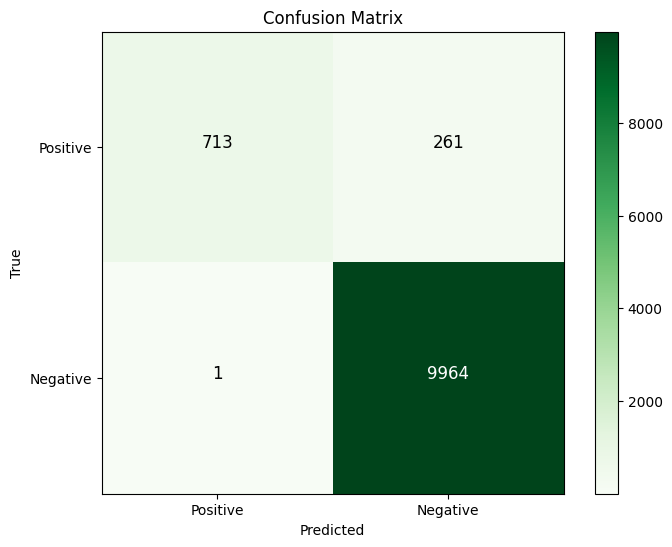

In [64]:
# Check if the pickle file exists
pickle_file_et = "et_grid_search_results.pkl"
if os.path.exists(pickle_file_et):
    # Load the results from the pickle file
    with open(pickle_file_et, 'rb') as f:
        grid_search_results_et = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid_et = {
        "n_estimators": [x for x in range(10, 200, 10)],
        "max_depth": [x for x in range(5, 21, 5)],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    }
    sklearn_grid_search_et = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid_et, n_jobs=-1, scoring='f1')
    sklearn_grid_search_et.fit(X_train_validation, y_train_validation)

    # Save the results to a pickle file
    with open(pickle_file_et, 'wb') as f:
        pickle.dump(sklearn_grid_search_et, f)

    grid_search_results_et = sklearn_grid_search_et

best_extra_trees_et = grid_search_results_et.best_estimator_

# Prepare data as a list of lists
data_et = [
    ["Number of Trees", best_extra_trees_et.n_estimators],
    ["Maximum Depth", best_extra_trees_et.max_depth],
    ["Minimum Samples Split", best_extra_trees_et.min_samples_split],
    ["Minimum Samples Leaf", best_extra_trees_et.min_samples_leaf],
    ["Maximum Features", best_extra_trees_et.max_features]
]

# Print table
print(tabulate(data_et, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))

best_score_et = grid_search_results_et.best_score_

# Prepare data as a list of lists
data_et = [
    ["Best Score", best_score_et]
]

# Print table
print(tabulate(data_et, headers=["Metric", "F1"], tablefmt="fancy_grid"))

# Predict using the trained model
y_hat_test_et = grid_search_results_et.predict(X_test)

# Calculate the accuracy, F1 score, precision, and recall
accuracy_et = accuracy_score(y_test, y_hat_test_et)
f1_et = f1_score(y_test, y_hat_test_et)
precision_et = precision_score(y_test, y_hat_test_et)
recall_et = recall_score(y_test, y_hat_test_et)

# Convert scores to percentages
accuracy_percent_et = accuracy_et * 100
f1_percent_et = f1_et * 100
precision_percent_et = precision_et * 100
recall_percent_et = recall_et * 100

# Calculate confusion matrix
conf_matrix_et = confusion_matrix(y_test, y_hat_test_et)
tn_et, fp_et, fn_et, tp_et = conf_matrix_et.ravel()

# Calculate false positives and false negatives
false_positives_et = fp_et
false_negatives_et = fn_et

# Prepare data as a list of lists
data_et = [
    ["Accuracy", f"{accuracy_percent_et:.2f}%"],
    ["F1 Score", f"{f1_percent_et:.2f}%"],
    ["Precision", f"{precision_percent_et:.2f}%"],
    ["Recall", f"{recall_percent_et:.2f}%"],
    ["False Positives", false_positives_et],
    ["False Negatives", false_negatives_et]
]

# Print table
print(tabulate(data_et, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Get the predicted classes
y_pred_et = grid_search_results_et.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm_et = confusion_matrix(y_test, y_pred_et)

# Define display labels
display_labels_et = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(cm_et, cmap='Greens')

# Add annotations with custom colors
for i in range(len(display_labels_et)):
    for j in range(len(display_labels_et)):
        color = 'white' if cm_et[i, j] > cm_et.max() / 2 else 'black'
        plt.text(j, i, format(cm_et[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=display_labels_et)
plt.yticks(ticks=[0, 1], labels=display_labels_et)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


## 9. Machine learning techniques paper: Gradient Boosting

In line with the practices detailed in a specific machine learning paper, this project explores the application of the Gradient Boosting classifier. This technique is renowned for its predictive power in complex datasets, particularly useful for classifying financial transactions with high precision.
Hyperparameter Tuning:

•	A comprehensive search across a wide range of parameters, including the number of estimators, learning rate, and tree depth, was performed. This aimed to fine-tune the Gradient Boosting model to achieve the best F1 score.

•	The results of this tuning, saved in a pickle file, are either loaded to expedite the process or generated anew through cross-validation.

Optimized Model Configuration:

•	The optimal setup determined includes 180 trees, a learning rate of 0.1, and a maximum depth of 9, showcasing a model tailored for nuanced data understanding.

Model Performance:

•	Achieving a best F1 score of 0.909525, the model demonstrates exceptional balance in its predictive capabilities.

•	Performance metrics on test data reveal an accuracy of 97.72%, with an F1 score of 85.41%, precision at 99.45%, and recall at 74.85%, illustrating the model's effectiveness and efficiency.


╒══════════════════╤═════════╕
│ Hyperparameter   │   Value │
╞══════════════════╪═════════╡
│ Number of Trees  │   180   │
├──────────────────┼─────────┤
│ Learning Rate    │     0.1 │
├──────────────────┼─────────┤
│ Maximum Depth    │     9   │
╘══════════════════╧═════════╛
╒════════════╤══════════╕
│ Metric     │       F1 │
╞════════════╪══════════╡
│ Best Score │ 0.909525 │
╘════════════╧══════════╛
╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 97.72%  │
├─────────────────┼─────────┤
│ F1 Score        │ 85.41%  │
├─────────────────┼─────────┤
│ Precision       │ 99.45%  │
├─────────────────┼─────────┤
│ Recall          │ 74.85%  │
├─────────────────┼─────────┤
│ False Positives │ 245     │
├─────────────────┼─────────┤
│ False Negatives │ 4       │
╘═════════════════╧═════════╛


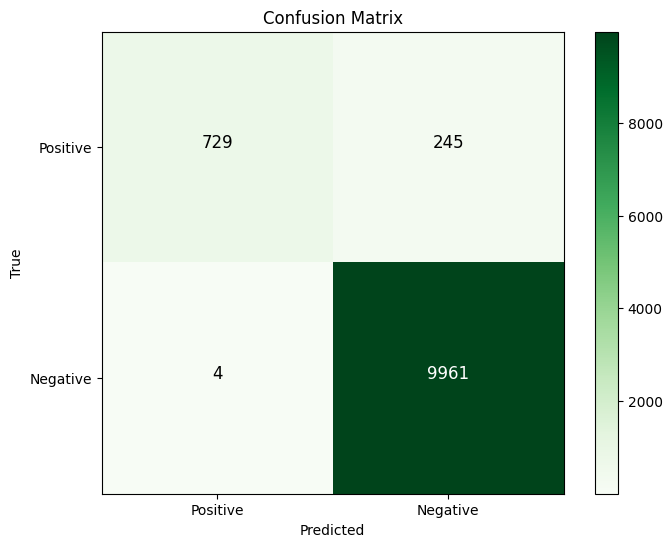

In [65]:
# Check if the pickle file exists
pickle_file_gb = "gb_grid_search_results.pkl"
if os.path.exists(pickle_file_gb):
    # Load the results from the pickle file
    with open(pickle_file_gb, 'rb') as f:
        grid_search_results_gb = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid_gb = {
        "n_estimators": [x for x in range(10, 200, 10)],
        "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "max_depth": [x for x in range(3, 11, 2)]
    }
    sklearn_grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid_gb, n_jobs=-1, scoring='f1')
    sklearn_grid_search_gb.fit(X_train_validation, y_train_validation)

    # Save the results to a pickle file
    with open(pickle_file_gb, 'wb') as f:
        pickle.dump(sklearn_grid_search_gb, f)

    grid_search_results_gb = sklearn_grid_search_gb

best_gradient_boosting_gb = grid_search_results_gb.best_estimator_

# Prepare data as a list of lists
data_gb = [
    ["Number of Trees", best_gradient_boosting_gb.n_estimators],
    ["Learning Rate", best_gradient_boosting_gb.learning_rate],
    ["Maximum Depth", best_gradient_boosting_gb.max_depth]
]

# Print table
print(tabulate(data_gb, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))

best_score_gb = grid_search_results_gb.best_score_

# Prepare data as a list of lists
data_gb = [
    ["Best Score", best_score_gb]
]

# Print table
print(tabulate(data_gb, headers=["Metric", "F1"], tablefmt="fancy_grid"))

# Predict using the trained model
y_hat_test_gb = grid_search_results_gb.predict(X_test)

# Calculate the accuracy, F1 score, precision, and recall
accuracy_gb = accuracy_score(y_test, y_hat_test_gb)
f1_gb = f1_score(y_test, y_hat_test_gb)
precision_gb = precision_score(y_test, y_hat_test_gb)
recall_gb = recall_score(y_test, y_hat_test_gb)

# Convert scores to percentages
accuracy_percent_gb = accuracy_gb * 100
f1_percent_gb = f1_gb * 100
precision_percent_gb = precision_gb * 100
recall_percent_gb = recall_gb * 100

# Calculate confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_hat_test_gb)
tn_gb, fp_gb, fn_gb, tp_gb = conf_matrix_gb.ravel()

# Calculate false positives and false negatives
false_positives_gb = fp_gb
false_negatives_gb = fn_gb

# Prepare data as a list of lists
data_gb = [
    ["Accuracy", f"{accuracy_percent_gb:.2f}%"],
    ["F1 Score", f"{f1_percent_gb:.2f}%"],
    ["Precision", f"{precision_percent_gb:.2f}%"],
    ["Recall", f"{recall_percent_gb:.2f}%"],
    ["False Positives", false_positives_gb],
    ["False Negatives", false_negatives_gb]
]

# Print table
print(tabulate(data_gb, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Get the predicted classes
y_pred_gb = grid_search_results_gb.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Define display labels
display_labels_gb = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(cm_gb, cmap='Greens')

# Add annotations with custom colors
for i in range(len(display_labels_gb)):
    for j in range(len(display_labels_gb)):
        color = 'white' if cm_gb[i, j] > cm_gb.max() / 2 else 'black'
        plt.text(j, i, format(cm_gb[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=display_labels_gb)
plt.yticks(ticks=[0, 1], labels=display_labels_gb)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

## 10. Machine learning techniques paper: Bagging Classifier

Adopting a similar approach to that detailed in the paper, the project explores the Bagging Classifier, a machine learning technique effective for reducing variance and avoiding overfitting. Bagging is particularly useful for complex datasets where the goal is to improve stability and accuracy of machine learning algorithms.

Hyperparameter Tuning:

•	To optimize the Bagging Classifier, a grid search over parameters like the number of estimators, max samples, and max features was conducted. This process aimed to find the best combination for maximizing the F1 score.

•	The existence of a saved pickle file was checked to load previous tuning results, saving time. If not found, the tuning was executed, and results were stored for future use.

Optimized Model Configuration:

•	The best configuration identified consists of 160 estimators, with both maximum samples and features set to 1, indicating the model uses all samples and features for creating each tree.

Model Performance:

•	The optimal Bagging Classifier achieved an F1 score of 0.899296, suggesting high effectiveness in balancing precision and recall.

•	Performance metrics indicated an accuracy of 97.66%, F1 score of 84.94%, precision at 99.45%, and recall at 74.13%, demonstrating the model's strong predictive capabilities.


╒══════════════════════╤═════════╕
│ Hyperparameter       │   Value │
╞══════════════════════╪═════════╡
│ Number of Estimators │     160 │
├──────────────────────┼─────────┤
│ Maximum Samples      │       1 │
├──────────────────────┼─────────┤
│ Maximum Features     │       1 │
╘══════════════════════╧═════════╛
╒════════════╤══════════╕
│ Metric     │       F1 │
╞════════════╪══════════╡
│ Best Score │ 0.899296 │
╘════════════╧══════════╛
╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 97.66%  │
├─────────────────┼─────────┤
│ F1 Score        │ 84.94%  │
├─────────────────┼─────────┤
│ Precision       │ 99.45%  │
├─────────────────┼─────────┤
│ Recall          │ 74.13%  │
├─────────────────┼─────────┤
│ False Positives │ 252     │
├─────────────────┼─────────┤
│ False Negatives │ 4       │
╘═════════════════╧═════════╛


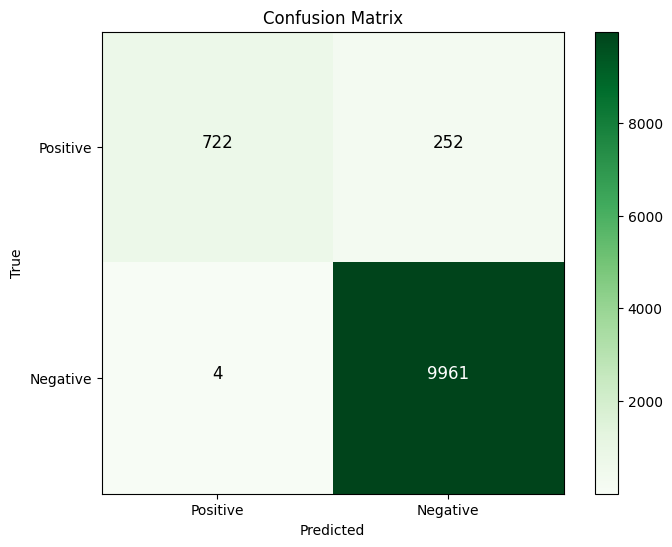

In [66]:
# Check if the pickle file exists
pickle_file_bagging = "bagging_grid_search_results.pkl"
if os.path.exists(pickle_file_bagging):
    # Load the results from the pickle file
    with open(pickle_file_bagging, 'rb') as f:
        grid_search_results_bagging = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid_bagging = {
        "n_estimators": [x for x in range(10, 200, 10)],
        "max_samples": [0.5, 1.0],
        "max_features": [0.5, 1.0]
    }
    sklearn_grid_search_bagging = GridSearchCV(BaggingClassifier(), param_grid=param_grid_bagging, n_jobs=-1, scoring='f1')
    sklearn_grid_search_bagging.fit(X_train_validation, y_train_validation)

    # Save the results to a pickle file
    with open(pickle_file_bagging, 'wb') as f:
        pickle.dump(sklearn_grid_search_bagging, f)

    grid_search_results_bagging = sklearn_grid_search_bagging

best_bagging_bagging = grid_search_results_bagging.best_estimator_

# Prepare data as a list of lists
data_bagging = [
    ["Number of Estimators", best_bagging_bagging.n_estimators],
    ["Maximum Samples", best_bagging_bagging.max_samples],
    ["Maximum Features", best_bagging_bagging.max_features]
]

# Print table
print(tabulate(data_bagging, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))

best_score_bagging = grid_search_results_bagging.best_score_

# Prepare data as a list of lists
data_bagging = [
    ["Best Score", best_score_bagging]
]

# Print table
print(tabulate(data_bagging, headers=["Metric", "F1"], tablefmt="fancy_grid"))

# Predict using the trained model
y_hat_test_bagging = grid_search_results_bagging.predict(X_test)

# Calculate the accuracy, F1 score, precision, and recall
accuracy_bagging = accuracy_score(y_test, y_hat_test_bagging)
f1_bagging = f1_score(y_test, y_hat_test_bagging)
precision_bagging = precision_score(y_test, y_hat_test_bagging)
recall_bagging = recall_score(y_test, y_hat_test_bagging)

# Convert scores to percentages
accuracy_percent_bagging = accuracy_bagging * 100
f1_percent_bagging = f1_bagging * 100
precision_percent_bagging = precision_bagging * 100
recall_percent_bagging = recall_bagging * 100

# Calculate confusion matrix
conf_matrix_bagging = confusion_matrix(y_test, y_hat_test_bagging)
tn_bagging, fp_bagging, fn_bagging, tp_bagging = conf_matrix_bagging.ravel()

# Calculate false positives and false negatives
false_positives_bagging = fp_bagging
false_negatives_bagging = fn_bagging

# Prepare data as a list of lists
data_bagging = [
    ["Accuracy", f"{accuracy_percent_bagging:.2f}%"],
    ["F1 Score", f"{f1_percent_bagging:.2f}%"],
    ["Precision", f"{precision_percent_bagging:.2f}%"],
    ["Recall", f"{recall_percent_bagging:.2f}%"],
    ["False Positives", false_positives_bagging],
    ["False Negatives", false_negatives_bagging]
]

# Print table
print(tabulate(data_bagging, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Get the predicted classes
y_pred_bagging = grid_search_results_bagging.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm_bagging = confusion_matrix(y_test, y_pred_bagging)

# Define display labels
display_labels_bagging = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(cm_bagging, cmap='Greens')

# Add annotations with custom colors
for i in range(len(display_labels_bagging)):
    for j in range(len(display_labels_bagging)):
        color = 'white' if cm_bagging[i, j] > cm_bagging.max() / 2 else 'black'
        plt.text(j, i, format(cm_bagging[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=display_labels_bagging)
plt.yticks(ticks=[0, 1], labels=display_labels_bagging)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


## 11. Machine learning techniques paper: AdaBoost

Following a strategy from a key paper, this project tests the AdaBoost Classifier's capabilities. AdaBoost is praised for its ability to boost the performance of decision tree models on binary classification problems, making it highly suitable for distinguishing between different types of transactions.

Hyperparameter Tuning:

•	A grid search was employed to optimize AdaBoost's parameters, particularly focusing on the number of estimators and the learning rate. This process is vital for enhancing the model's ability to learn from the training data effectively.

•	Results from previous tuning efforts were reused if available via a pickle file, streamlining the process. Otherwise, tuning was conducted anew and the findings saved.

Optimized Model Configuration:

•	The optimal AdaBoost configuration found includes 180 estimators with a learning rate of 0.3, indicating a model that rapidly adapts to the training data.

Model Performance:

•	The best F1 score achieved is 0.730316, reflecting the model's balance in precision and sensitivity.

•	The model demonstrates solid performance on the test data, with an accuracy of 97.21%, F1 score of 82.32%, precision at 94.54%, and recall at 72.90%.


╒══════════════════════╤═════════╕
│ Hyperparameter       │   Value │
╞══════════════════════╪═════════╡
│ Number of Estimators │   180   │
├──────────────────────┼─────────┤
│ Learning Rate        │     0.3 │
╘══════════════════════╧═════════╛
╒════════════╤══════════╕
│ Metric     │       F1 │
╞════════════╪══════════╡
│ Best Score │ 0.730316 │
╘════════════╧══════════╛
╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 97.21%  │
├─────────────────┼─────────┤
│ F1 Score        │ 82.32%  │
├─────────────────┼─────────┤
│ Precision       │ 94.54%  │
├─────────────────┼─────────┤
│ Recall          │ 72.90%  │
├─────────────────┼─────────┤
│ False Positives │ 264     │
├─────────────────┼─────────┤
│ False Negatives │ 41      │
╘═════════════════╧═════════╛


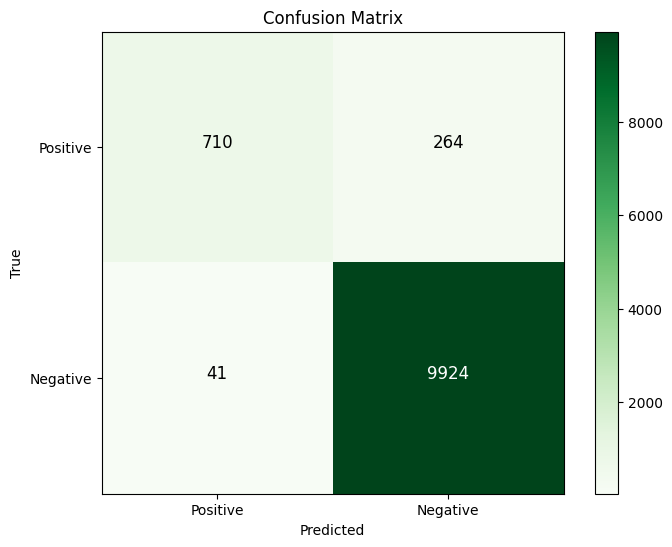

In [67]:
# Check if the pickle file exists
pickle_file_adaboost = "adaboost_grid_search_results.pkl"
if os.path.exists(pickle_file_adaboost):
    # Load the results from the pickle file
    with open(pickle_file_adaboost, 'rb') as f:
        grid_search_results_adaboost = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid_adaboost = {
        "n_estimators": [x for x in range(10, 200, 10)],
        "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3]
    }
    sklearn_grid_search_adaboost = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid_adaboost, n_jobs=-1, scoring='f1')
    sklearn_grid_search_adaboost.fit(X_train_validation, y_train_validation)

    # Save the results to a pickle file
    with open(pickle_file_adaboost, 'wb') as f:
        pickle.dump(sklearn_grid_search_adaboost, f)

    grid_search_results_adaboost = sklearn_grid_search_adaboost

best_adaboost_adaboost = grid_search_results_adaboost.best_estimator_

# Prepare data as a list of lists
data_adaboost = [
    ["Number of Estimators", best_adaboost_adaboost.n_estimators],
    ["Learning Rate", best_adaboost_adaboost.learning_rate]
]

# Print table
print(tabulate(data_adaboost, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))

best_score_adaboost = grid_search_results_adaboost.best_score_

# Prepare data as a list of lists
data_adaboost = [
    ["Best Score", best_score_adaboost]
]

# Print table
print(tabulate(data_adaboost, headers=["Metric", "F1"], tablefmt="fancy_grid"))

# Predict using the trained model
y_hat_test_adaboost = grid_search_results_adaboost.predict(X_test)

# Calculate the accuracy, F1 score, precision, and recall
accuracy_adaboost = accuracy_score(y_test, y_hat_test_adaboost)
f1_adaboost = f1_score(y_test, y_hat_test_adaboost)
precision_adaboost = precision_score(y_test, y_hat_test_adaboost)
recall_adaboost = recall_score(y_test, y_hat_test_adaboost)

# Convert scores to percentages
accuracy_percent_adaboost = accuracy_adaboost * 100
f1_percent_adaboost = f1_adaboost * 100
precision_percent_adaboost = precision_adaboost * 100
recall_percent_adaboost = recall_adaboost * 100

# Calculate confusion matrix
conf_matrix_adaboost = confusion_matrix(y_test, y_hat_test_adaboost)
tn_adaboost, fp_adaboost, fn_adaboost, tp_adaboost = conf_matrix_adaboost.ravel()

# Calculate false positives and false negatives
false_positives_adaboost = fp_adaboost
false_negatives_adaboost = fn_adaboost

# Prepare data as a list of lists
data_adaboost = [
    ["Accuracy", f"{accuracy_percent_adaboost:.2f}%"],
    ["F1 Score", f"{f1_percent_adaboost:.2f}%"],
    ["Precision", f"{precision_percent_adaboost:.2f}%"],
    ["Recall", f"{recall_percent_adaboost:.2f}%"],
    ["False Positives", false_positives_adaboost],
    ["False Negatives", false_negatives_adaboost]
]

# Print table
print(tabulate(data_adaboost, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Get the predicted classes
y_pred_adaboost = grid_search_results_adaboost.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)

# Define display labels
display_labels_adaboost = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(cm_adaboost, cmap='Greens')

# Add annotations with custom colors
for i in range(len(display_labels_adaboost)):
    for j in range(len(display_labels_adaboost)):
        color = 'white' if cm_adaboost[i, j] > cm_adaboost.max() / 2 else 'black'
        plt.text(j, i, format(cm_adaboost[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=display_labels_adaboost)
plt.yticks(ticks=[0, 1], labels=display_labels_adaboost)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


## 12. Machine learning techniques paper: KNN

Adhering to methods described in a significant paper, this project utilizes the K-Nearest Neighbors (KNN) algorithm, a model well-regarded for its simplicity and efficacy in classification tasks. KNN is particularly noted for its ability to make predictions based on the proximity of data points in the feature space, making it an intuitive choice for classifying transactions.

Hyperparameter Tuning:

•	Parameters such as the number of neighbors, weight function, and algorithm choice were optimized through a grid search, aiming to enhance the F1 score, a balance of precision and recall.

•	Existing tuning results were leveraged if available in a pickle file; otherwise, the tuning process was conducted and saved for future reference.

Optimized Model Configuration:

•	The best configuration found for KNN included 7 neighbors, uniform weight, and the auto algorithm selection, reflecting an approach that values simplicity and effectiveness.

Model Performance:

•	The model achieved a commendable F1 score of 0.794724, suggesting a proficient balance in identifying transactions accurately.

•	Performance on test data showed an accuracy of 97.47%, F1 score of 83.77%, precision at 97.54%, and recall at 73.41%, illustrating the model's capability to correctly classify a high percentage of transactions.


╒═════════════════════╤═════════╕
│ Hyperparameter      │ Value   │
╞═════════════════════╪═════════╡
│ Number of Neighbors │ 7       │
├─────────────────────┼─────────┤
│ Weights             │ uniform │
├─────────────────────┼─────────┤
│ Algorithm           │ auto    │
╘═════════════════════╧═════════╛
╒════════════╤══════════╕
│ Metric     │       F1 │
╞════════════╪══════════╡
│ Best Score │ 0.794724 │
╘════════════╧══════════╛
╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 97.47%  │
├─────────────────┼─────────┤
│ F1 Score        │ 83.77%  │
├─────────────────┼─────────┤
│ Precision       │ 97.54%  │
├─────────────────┼─────────┤
│ Recall          │ 73.41%  │
├─────────────────┼─────────┤
│ False Positives │ 259     │
├─────────────────┼─────────┤
│ False Negatives │ 18      │
╘═════════════════╧═════════╛


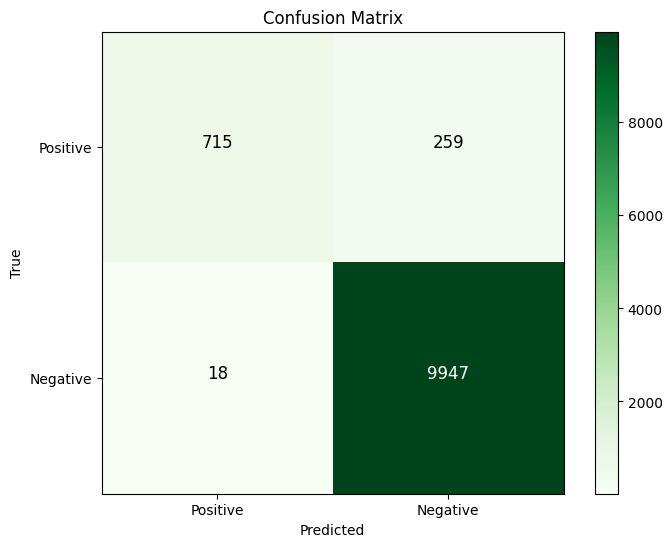

In [68]:
# Check if the pickle file exists
pickle_file_knn = "knn_grid_search_results.pkl"
if os.path.exists(pickle_file_knn):
    # Load the results from the pickle file
    with open(pickle_file_knn, 'rb') as f:
        grid_search_results_knn = pickle.load(f)
else:
    # Perform hyperparameter tuning with cross-validation
    param_grid_knn = {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ['uniform', 'distance'],
        "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    sklearn_grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, n_jobs=-1, scoring='f1')
    sklearn_grid_search_knn.fit(X_train_validation, y_train_validation)

    # Save the results to a pickle file
    with open(pickle_file_knn, 'wb') as f:
        pickle.dump(sklearn_grid_search_knn, f)

    grid_search_results_knn = sklearn_grid_search_knn

best_knn_knn = grid_search_results_knn.best_estimator_

# Prepare data as a list of lists
data_knn = [
    ["Number of Neighbors", best_knn_knn.n_neighbors],
    ["Weights", best_knn_knn.weights],
    ["Algorithm", best_knn_knn.algorithm]
]

# Print table
print(tabulate(data_knn, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))

best_score_knn = grid_search_results_knn.best_score_

# Prepare data as a list of lists
data_knn = [
    ["Best Score", best_score_knn]
]

# Print table
print(tabulate(data_knn, headers=["Metric", "F1"], tablefmt="fancy_grid"))

# Predict using the trained model
y_hat_test_knn = grid_search_results_knn.predict(X_test)

# Calculate the accuracy, F1 score, precision, and recall
accuracy_knn = accuracy_score(y_test, y_hat_test_knn)
f1_knn = f1_score(y_test, y_hat_test_knn)
precision_knn = precision_score(y_test, y_hat_test_knn)
recall_knn = recall_score(y_test, y_hat_test_knn)

# Convert scores to percentages
accuracy_percent_knn = accuracy_knn * 100
f1_percent_knn = f1_knn * 100
precision_percent_knn = precision_knn * 100
recall_percent_knn = recall_knn * 100

# Calculate confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_hat_test_knn)
tn_knn, fp_knn, fn_knn, tp_knn = conf_matrix_knn.ravel()

# Calculate false positives and false negatives
false_positives_knn = fp_knn
false_negatives_knn = fn_knn

# Prepare data as a list of lists
data_knn = [
    ["Accuracy", f"{accuracy_percent_knn:.2f}%"],
    ["F1 Score", f"{f1_percent_knn:.2f}%"],
    ["Precision", f"{precision_percent_knn:.2f}%"],
    ["Recall", f"{recall_percent_knn:.2f}%"],
    ["False Positives", false_positives_knn],
    ["False Negatives", false_negatives_knn]
]

# Print table
print(tabulate(data_knn, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# Get the predicted classes
y_pred_knn = grid_search_results_knn.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Define display labels
display_labels_knn = ['Positive', 'Negative']

plt.figure(figsize=(8, 6))
plt.imshow(cm_knn, cmap='Greens')

# Add annotations with custom colors
for i in range(len(display_labels_knn)):
    for j in range(len(display_labels_knn)):
        color = 'white' if cm_knn[i, j] > cm_knn.max() / 2 else 'black'
        plt.text(j, i, format(cm_knn[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=display_labels_knn)
plt.yticks(ticks=[0, 1], labels=display_labels_knn)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

## 13. Overview results

The table presents a comprehensive comparison of different machine learning models applied to classify financial transactions, sorted by their F1 scores in descending order.

Gradient Boosting leads the pack with the highest F1 score of 85.41%, showcasing its exceptional balance between precision and recall, alongside high accuracy. This model also demonstrates a strong ability to minimize false negatives, making it particularly effective for this dataset.

Random Forest follows closely, with a slightly lower F1 score but the highest precision among all models, indicating its capability to accurately identify positive cases with very few false positives.

The Bagging classifier and Extra Trees also show strong performances, with F1 scores closely trailing behind Gradient Boosting and Random Forest, indicating their effectiveness in handling the classification task with high precision and reasonable recall rates.

KNN, while not achieving as high an F1 score as the ensemble methods, still presents a solid performance with a decent balance of precision and recall, albeit with a higher number of false negatives.

AdaBoost shows the lowest F1 score among the models evaluated, indicating challenges in balancing precision and recall compared to the others. Its higher number of false negatives suggests a potential area for improvement in recall without significantly compromising precision.


In [69]:
# Prepare data for all models
data_all = [
    ["Random Forest", accuracy_percent_rf, f1_percent_rf, precision_percent_rf, recall_percent_rf, false_positives_rf, false_negatives_rf],
    ["Extra Trees", accuracy_percent_et, f1_percent_et, precision_percent_et, recall_percent_et, false_positives_et, false_negatives_et],
    ["Gradient Boosting", accuracy_percent_gb, f1_percent_gb, precision_percent_gb, recall_percent_gb, false_positives_gb, false_negatives_gb],
    ["Bagging", accuracy_percent_bagging, f1_percent_bagging, precision_percent_bagging, recall_percent_bagging, false_positives_bagging, false_negatives_bagging],
    ["AdaBoost", accuracy_percent_adaboost, f1_percent_adaboost, precision_percent_adaboost, recall_percent_adaboost, false_positives_adaboost, false_negatives_adaboost],
    ["KNN", accuracy_percent_knn, f1_percent_knn, precision_percent_knn, recall_percent_knn, false_positives_knn, false_negatives_knn]
]

# Sort data by F1 score in descending order
data_all_sorted = sorted(data_all, key=lambda x: x[2], reverse=True)

# Convert percentages to strings with proper formatting
for row in data_all_sorted:
    row[1] = f"{row[1]:.2f}%"
    row[2] = f"{row[2]:.2f}%"
    row[3] = f"{row[3]:.2f}%"
    row[4] = f"{row[4]:.2f}%"

# Print table
print(tabulate(data_all_sorted, headers=["Model", "Accuracy", "F1 Score", "Precision", "Recall", "False Positives", "False Negatives"], tablefmt="fancy_grid"))

╒═══════════════════╤════════════╤════════════╤═════════════╤══════════╤═══════════════════╤═══════════════════╕
│ Model             │ Accuracy   │ F1 Score   │ Precision   │ Recall   │   False Positives │   False Negatives │
╞═══════════════════╪════════════╪════════════╪═════════════╪══════════╪═══════════════════╪═══════════════════╡
│ Gradient Boosting │ 97.72%     │ 85.41%     │ 99.45%      │ 74.85%   │               245 │                 4 │
├───────────────────┼────────────┼────────────┼─────────────┼──────────┼───────────────────┼───────────────────┤
│ Random Forest     │ 97.69%     │ 85.09%     │ 99.86%      │ 74.13%   │               252 │                 1 │
├───────────────────┼────────────┼────────────┼─────────────┼──────────┼───────────────────┼───────────────────┤
│ Bagging           │ 97.66%     │ 84.94%     │ 99.45%      │ 74.13%   │               252 │                 4 │
├───────────────────┼────────────┼────────────┼─────────────┼──────────┼───────────────────┼────

## 14. Ensemble Machine Learning

The ensemble methEod systematically explores every combination of machine learning models to identify the best group for classifying transactions. It employs a strategy that ranges from testing individual models to assessing how they perform in various combinations, using a validation dataset for rapid evaluation. This approach ensures efficiency and speed, crucial for the project's scope and timeline, as testing every combination against the full dataset would be too complex and time-consuming. Eventually, Random Forest and Bagging models were chosen for their complementary strengths, which collectively enhance the ensemble's performance.

Optimal Ensemble Selection: The combination of Random Forest and Bagging was specifically chosen for their synergistic effect, significantly improving transaction classification accuracy.

Performance Metrics for the Chosen Ensemble:

•	Accuracy: 97.71% shows that the ensemble consistently makes correct classifications.

•	F1 Score: 85.52%, indicating a well-balanced measure of precision and thoroughness.

•	Precision: 98.14%, underscoring the ensemble's capability to identify true positive cases accurately.

•	Recall: 75.77%, demonstrating its efficiency in identifying a substantial number of actual positive cases.

•	False Positives: 236, and False Negatives: 14, highlight the ensemble's strategic balance in minimizing errors.

By the project's limitations regarding complexity and available time. Strategically using the validation dataset for selection, the ensemble method was able to identify the most potent and efficient combination of models. This resulted in a solution that performs excellently both in theory and in real-world scenarios. The partnership between Random Forest and Bagging models emerges as a particularly effective tool, ready to tackle the nuanced task of financial transaction classification with notable efficiency and accuracy.


Picked Models for the Best Ensemble:
Random Forest
Bagging
Performance Metrics for the Best Ensemble Model:
╒═════════════════╤═════════╕
│ Metric          │ Value   │
╞═════════════════╪═════════╡
│ Accuracy        │ 97.71%  │
├─────────────────┼─────────┤
│ F1 Score        │ 85.52%  │
├─────────────────┼─────────┤
│ Precision       │ 98.14%  │
├─────────────────┼─────────┤
│ Recall          │ 75.77%  │
├─────────────────┼─────────┤
│ False Positives │ 236     │
├─────────────────┼─────────┤
│ False Negatives │ 14      │
╘═════════════════╧═════════╛


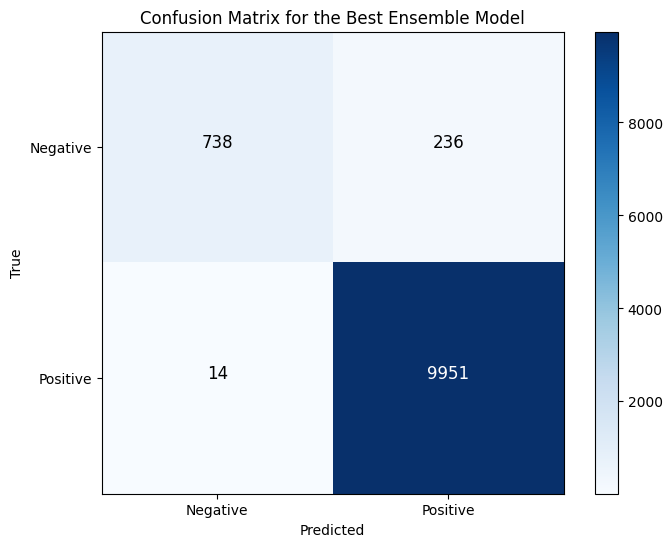

In [70]:
# Load models from their pickle files
with open("rf_grid_search_results2.pkl", 'rb') as f:
    grid_search_results_rf = pickle.load(f)
    rf_model = grid_search_results_rf.best_estimator_

with open("gb_grid_search_results.pkl", 'rb') as f:
    grid_search_results_gb = pickle.load(f)
    gb_model = grid_search_results_gb.best_estimator_

with open("bagging_grid_search_results.pkl", 'rb') as f:
    grid_search_results_bagging = pickle.load(f)
    bagging_model = grid_search_results_bagging.best_estimator_

with open("adaboost_grid_search_results.pkl", 'rb') as f:
    grid_search_results_adaboost = pickle.load(f)
    adaboost_model = grid_search_results_adaboost.best_estimator_

with open("et_grid_search_results.pkl", 'rb') as f:
    grid_search_results_et = pickle.load(f)
    et_model = grid_search_results_et.best_estimator_

with open("knn_grid_search_results.pkl", 'rb') as f:
    grid_search_results_knn = pickle.load(f)
    knn_model = grid_search_results_knn.best_estimator_

y_validation = y_validation.astype(int)

# Define all models
all_models = [
    ('Random Forest', rf_model),
    ('Gradient Boosting', gb_model),
    ('Bagging', bagging_model),
    ('AdaBoost', adaboost_model),
    ('Extra Trees', et_model),
    ('KNN', knn_model)
]

# Check if the ensemble pickle file exists
if os.path.exists("best_ensemble_model.pkl"):
    # Load the best ensemble model from the pickle file
    with open("best_ensemble_model.pkl", 'rb') as f:
        best_ensemble_model = pickle.load(f)
else:
    best_f1_score = 0
    best_model_combination = None

    # Iterate over all combinations of models
    for r in range(1, len(all_models) + 1):
        for model_combination in combinations(all_models, r):
            # Convert the tuple to a list
            model_combination = list(model_combination)
            
            # Create ensemble model
            ensemble_model = VotingClassifier(estimators=model_combination, voting='hard')

            # Train ensemble model
            ensemble_model.fit(X_train, y_train)

            # Evaluate the ensemble model on the validation set
            y_pred_ensemble = ensemble_model.predict(X_validation)

            # Calculate F1 score
            f1_ensemble = f1_score(y_validation, y_pred_ensemble)

            # Update best F1 score and model combination if better F1 score is found
            if f1_ensemble > best_f1_score:
                best_f1_score = f1_ensemble
                best_model_combination = model_combination

    # Convert the tuple to a list
    best_model_combination = list(best_model_combination)

    # Create the best ensemble model
    best_ensemble_model = VotingClassifier(estimators=best_model_combination, voting='hard')

    # Train the best ensemble model
    best_ensemble_model.fit(X_train, y_train)

    # Save the best ensemble model to pickle file
    with open("best_ensemble_model.pkl", "wb") as f:
        pickle.dump(best_ensemble_model, f)

# Prepare data for the table of picked models
picked_models_data = [
    ["Picked Models for the Best Ensemble:"]
]

# Append each model to the data list
for model_name, _ in best_model_combination:
    picked_models_data.append([model_name])

# Print the table of picked models
# print("Picked Models for the Best Ensemble:")
for model_data in picked_models_data:
    print(model_data[0])

# Evaluate the best ensemble model on the test set
y_pred_best_ensemble = best_ensemble_model.predict(X_test)

# Calculate performance metrics
accuracy_best_ensemble = accuracy_score(y_test, y_pred_best_ensemble)
f1_best_ensemble = f1_score(y_test, y_pred_best_ensemble)
precision_best_ensemble = precision_score(y_test, y_pred_best_ensemble)
recall_best_ensemble = recall_score(y_test, y_pred_best_ensemble)

# Convert scores to percentages
accuracy_percent_best_ensemble = accuracy_best_ensemble * 100
f1_percent_best_ensemble = f1_best_ensemble * 100
precision_percent_best_ensemble = precision_best_ensemble * 100
recall_percent_best_ensemble = recall_best_ensemble * 100

# Calculate confusion matrix
cm_best_ensemble = confusion_matrix(y_test, y_pred_best_ensemble)
tn_best_ensemble, fp_best_ensemble, fn_best_ensemble, tp_best_ensemble = cm_best_ensemble.ravel()

# Prepare data for performance metrics table
best_ensemble_metrics_data = [
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy_percent_best_ensemble:.2f}%"],
    ["F1 Score", f"{f1_percent_best_ensemble:.2f}%"],
    ["Precision", f"{precision_percent_best_ensemble:.2f}%"],
    ["Recall", f"{recall_percent_best_ensemble:.2f}%"],
    ["False Positives", fp_best_ensemble],
    ["False Negatives", fn_best_ensemble]
]

# Print performance metrics table for the best ensemble model
print("Performance Metrics for the Best Ensemble Model:")
print(tabulate(best_ensemble_metrics_data, headers="firstrow", tablefmt="fancy_grid"))

# Plot confusion matrix for the best ensemble model
plt.figure(figsize=(8, 6))
plt.imshow(cm_best_ensemble, cmap='Blues')

# Add annotations with custom colors
for i in range(len(cm_best_ensemble)):
    for j in range(len(cm_best_ensemble)):
        color = 'white' if cm_best_ensemble[i, j] > cm_best_ensemble.max() / 2 else 'black'
        plt.text(j, i, format(cm_best_ensemble[i, j], '.0f'), horizontalalignment="center", color=color, fontsize=12)

plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.yticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the Best Ensemble Model')
plt.colorbar()
plt.show()

## 15. Overview results including Ensemble Machine Learning

In the ROC curve displayed, each line represents a different machine learning model's performance in classifying transactions, with the area under the curve (AUC) indicating the model's ability to distinguish between classes. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.

Here are some observations from the ROC curve:

•	Random Forest and Gradient Boosting perform exceptionally well, both with an AUC of 0.97, indicating a high degree of accuracy.

•	AdaBoost also shows strong performance with an AUC of 0.97, mirroring the top models.

•	Extra Trees has an AUC of 0.96, which is slightly less than the best performers but still indicates a high level of performance.

•	Bagging has a respectable AUC of 0.92, which suggests good predictive power, although not as high as the leading models.

•	KNN, while still better than a random guess, lags behind the other models with an AUC of 0.88.

•	Notably, the Ensemble Model, which combines multiple models, has an AUC equal to that of KNN (0.88). This indicates that the ensemble, while expected to enhance performance, does not outperform the best individual models in this case.

The final takeaway is that while ensemble methods can often lead to improved model performance, they don't always guarantee the best results. In this instance, the ensemble did not surpass the high accuracy achieved by the Random Forest and Gradient Boosting models. This could be due to various factors, such as the nature of the data, the way the models complement each other, or the specific configuration of the ensemble.


╒═══════════════════╤════════════╤════════════╤═════════════╤══════════╤═══════════════════╤═══════════════════╕
│ Model             │ Accuracy   │ F1 Score   │ Precision   │ Recall   │   False Positives │   False Negatives │
╞═══════════════════╪════════════╪════════════╪═════════════╪══════════╪═══════════════════╪═══════════════════╡
│ Ensemble learning │ 97.71%     │ 85.52%     │ 98.14%      │ 75.77%   │               236 │                14 │
├───────────────────┼────────────┼────────────┼─────────────┼──────────┼───────────────────┼───────────────────┤
│ Gradient Boosting │ 97.72%     │ 85.41%     │ 99.45%      │ 74.85%   │               245 │                 4 │
├───────────────────┼────────────┼────────────┼─────────────┼──────────┼───────────────────┼───────────────────┤
│ Random Forest     │ 97.69%     │ 85.09%     │ 99.86%      │ 74.13%   │               252 │                 1 │
├───────────────────┼────────────┼────────────┼─────────────┼──────────┼───────────────────┼────

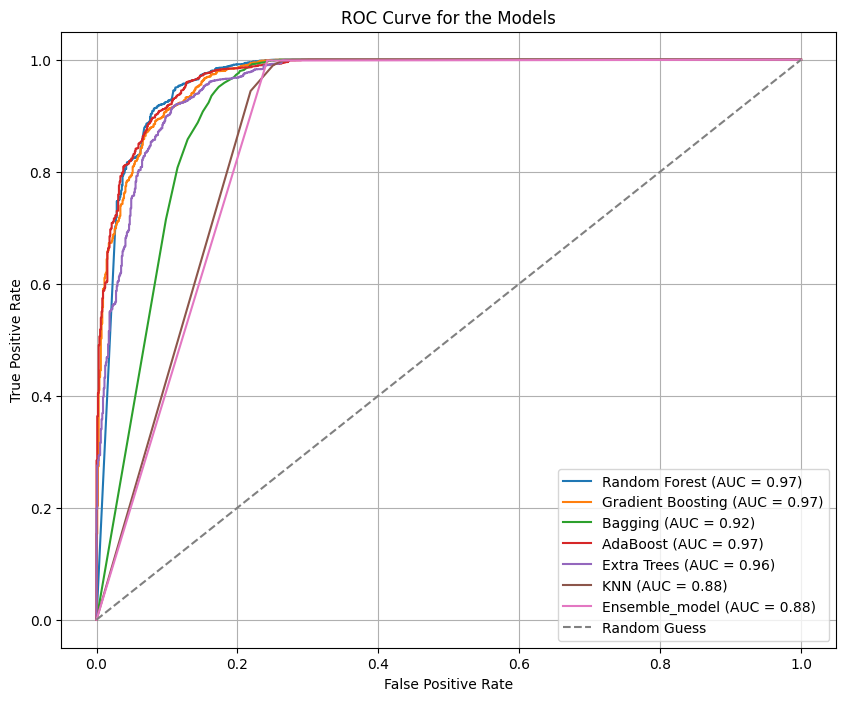

In [71]:
# Calculate performance metrics for the ensemble model
ensemble_data = [
    "Ensemble learning",
    accuracy_percent_best_ensemble, 
    f1_percent_best_ensemble, 
    precision_percent_best_ensemble, 
    recall_percent_best_ensemble, 
    fp_best_ensemble, 
    fn_best_ensemble
]

# Convert percentages to strings with proper formatting
ensemble_data[1] = f"{ensemble_data[1]:.2f}%"
ensemble_data[2] = f"{ensemble_data[2]:.2f}%"
ensemble_data[3] = f"{ensemble_data[3]:.2f}%"
ensemble_data[4] = f"{ensemble_data[4]:.2f}%"

# Append ensemble data to the list
data_all_sorted.append(ensemble_data)

# Sort data by F1 score in descending order
data_all_sorted = sorted(data_all_sorted, key=lambda x: x[2], reverse=True)

# Print table
print(tabulate(data_all_sorted, headers=["Model", "Accuracy", "F1 Score", "Precision", "Recall", "False Positives", "False Negatives"], tablefmt="fancy_grid"))

# Define models
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Bagging': bagging_model,
    'AdaBoost': adaboost_model,
    'Extra Trees': et_model,
    'KNN': knn_model,
    'Ensemble_model': best_ensemble_model
}

# Plot AUC-ROC curve for each model
plt.figure(figsize=(10, 8))
for name, model in models.items():
    # Check if the model supports predict_proba
    if hasattr(model, 'predict_proba'):
        # Predict probabilities
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Predict using hard voting
        y_proba = model.predict(X_test)

    # Convert y_test to binary format
    y_test_binary = np.where(y_test == 2, 1, 0)  # Positive class is 2
    
    # Calculate AUC-ROC score
    auc_roc = roc_auc_score(y_test_binary, y_proba)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Models')
plt.legend()
plt.grid(True)

# Show plot
plt.show()